In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import PIL
from PIL import Image
from skimage.color import rgb2gray
from scipy import ndimage as ndi
import cv2
import os
from os import listdir
from sklearn.utils import shuffle

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint


In [2]:
directory_root = "../input/plant-village-dataset/PlantVillageDataset/train_val_test/train"
print(len(listdir(directory_root)))

15


In [3]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
                
        for single_plant_disease_image in plant_disease_folder_list :
            if single_plant_disease_image == ".DS_Store" :
                plant_disease_folder_list.remove(single_plant_disease_image)

        for image in plant_disease_folder_list:
            image_directory = f"{directory_root}/{plant_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(image_directory)
                label_list.append(plant_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Image loading completed


In [4]:
img_info = pd.DataFrame({'image_path':image_list,'label':label_list})
print(img_info.head())
print(len(img_info))

                                          image_path  \
0  ../input/plant-village-dataset/PlantVillageDat...   
1  ../input/plant-village-dataset/PlantVillageDat...   
2  ../input/plant-village-dataset/PlantVillageDat...   
3  ../input/plant-village-dataset/PlantVillageDat...   
4  ../input/plant-village-dataset/PlantVillageDat...   

                           label  
0  Pepper__bell___Bacterial_spot  
1  Pepper__bell___Bacterial_spot  
2  Pepper__bell___Bacterial_spot  
3  Pepper__bell___Bacterial_spot  
4  Pepper__bell___Bacterial_spot  
14436


In [5]:
#new column (empty)
img_info["labels_integer"] = None
#index of new column
index_labels_integer = img_info.columns.get_loc("labels_integer")
#index of species column
index_species = img_info.columns.get_loc("label")
#to assign numeric labels starting with 0 for the first species
k = 0 
for i in range(len(img_info)):
    if i == 0:
        img_info.iloc[i, index_labels_integer] = k #here, k == 0
    if i > 0:
        if img_info.iloc[i-1, index_species] == img_info.iloc[i, index_species]:
            img_info.iloc[i, index_labels_integer] = k
        else:
            k += 1
            img_info.iloc[i, index_labels_integer] = k
img_info.tail()

,image_path,label,labels_integer
14431,../input/plant-village-dataset/PlantVillageDat...,Tomato__Tomato_mosaic_virus,14
14432,../input/plant-village-dataset/PlantVillageDat...,Tomato__Tomato_mosaic_virus,14
14433,../input/plant-village-dataset/PlantVillageDat...,Tomato__Tomato_mosaic_virus,14
14434,../input/plant-village-dataset/PlantVillageDat...,Tomato__Tomato_mosaic_virus,14
14435,../input/plant-village-dataset/PlantVillageDat...,Tomato__Tomato_mosaic_virus,14


In [6]:
img_info = shuffle(img_info)
list_vectors = []

for image_path in img_info.image_path:
    #read as rgb array
    img = Image.open(image_path)
    size = (64, 64)
    img = img.resize(size, PIL.Image.ANTIALIAS)  
    img_array = np.array(img)
    #append image vector to list
    list_vectors.append(img_array)
    
print(len(list_vectors))

/tmp/ipykernel_33/2472196027.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(size, PIL.Image.ANTIALIAS)


14436


In [7]:
X = np.stack((list_vectors))
Y =  img_info['labels_integer']
print(X.shape)

(14436, 64, 64, 3)


In [8]:
X = X/255
Y_one_hot = keras.utils.to_categorical(Y, num_classes=15)
print(Y.shape, Y_one_hot.shape)

(14436,) (14436, 15)


In [9]:
np.savez("x_images_arrayscnn", X)
np.savez("y_numeric_labelscnn", Y_one_hot)

In [10]:
x_npz = np.load("x_images_arrayscnn.npz")
X = x_npz['arr_0']

y_npz = np.load("y_numeric_labelscnn.npz")
Y_one_hot = y_npz['arr_0']

print(X.shape)

(14436, 64, 64, 3)


In [11]:
split_train = 0.8 #train 0.8, validate 0.1, test 0.1
split_val = 0.9
index_train = int(split_train*len(X))
index_val = int(split_val*len(X))

X_train = X[:index_train]
X_val = X[index_train:index_val]
X_test = X[index_val:]

Y_train = Y_one_hot[:index_train]
Y_val = Y_one_hot[index_train:index_val]
Y_test = Y_one_hot[index_val:]


print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(11548, 64, 64, 3) (1444, 64, 64, 3) (1444, 64, 64, 3) (11548, 15) (1444, 15) (1444, 15)


In [12]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]) 
num_classes = 15

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.7))
model.add(Flatten())
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.7))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        2432      
                                                                 
 activation (Activation)     (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        51264     
                                                                 
 activation_1 (Activation)   (None, 26, 26, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                    

In [14]:
best_model_file = "disease_selected_100.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

print('Training model...')
results = model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X_val, Y_val), callbacks=[best_model])
print('Traing finished.')

print('Loading the best model...')
model = load_model(best_model_file)
print('Best Model loaded!')

Training model...
Epoch 1/50
181/181 [==============================] - ETA: 0s - loss: 1.9062 - accuracy: 0.3970
Epoch 1: val_loss improved from inf to 1.20528, saving model to disease_selected_100.h5
181/181 [==============================] - 92s 504ms/step - loss: 1.9062 - accuracy: 0.3970 - val_loss: 1.2053 - val_accuracy: 0.6260
Epoch 2/50
181/181 [==============================] - ETA: 0s - loss: 1.1644 - accuracy: 0.6325
Epoch 2: val_loss improved from 1.20528 to 0.92394, saving model to disease_selected_100.h5
181/181 [==============================] - 89s 491ms/step - loss: 1.1644 - accuracy: 0.6325 - val_loss: 0.9239 - val_accuracy: 0.7071
Epoch 3/50
181/181 [==============================] - ETA: 0s - loss: 0.9089 - accuracy: 0.7043
Epoch 3: val_loss improved from 0.92394 to 0.71771, saving model to disease_selected_100.h5
181/181 [==============================] - 91s 505ms/step - loss: 0.9089 - accuracy: 0.7043 - val_loss: 0.7177 - val_accuracy: 0.7659
Epoch 4/50
181/181 [

In [15]:
model.evaluate(X_test, Y_test)

46/46 [==============================] - 3s 64ms/step - loss: 0.1703 - accuracy: 0.9494


[0.17026038467884064, 0.9494459629058838]

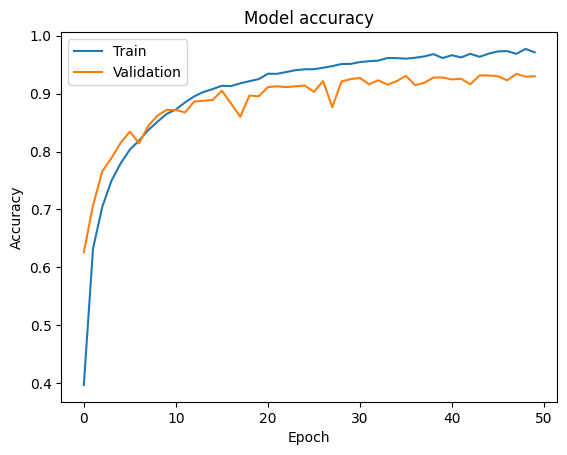

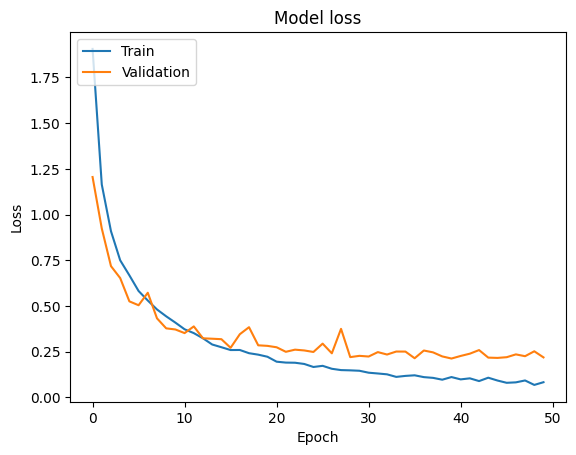

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(results.history['accuracy'])  # Use 'accuracy' instead of 'acc'
plt.plot(results.history['val_accuracy'])  # Use 'val_accuracy' instead of 'val_acc'
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


46/46 [==============================] - 3s 59ms/step


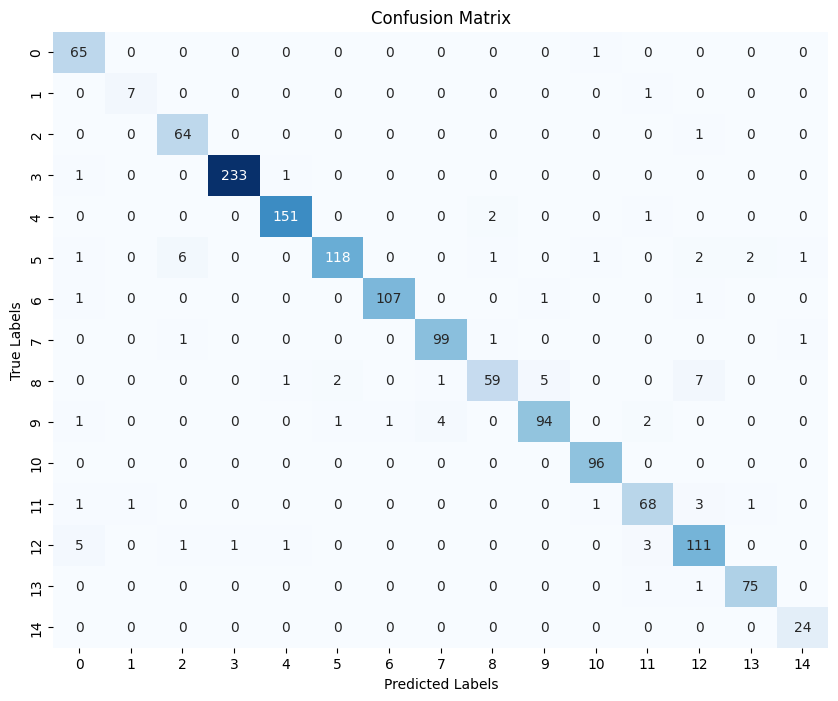

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predicted probabilities for each class
Y_pred_probabilities = model.predict(X_test)

# Convert predicted probabilities to class labels
Y_pred = np.argmax(Y_pred_probabilities, axis=1)

# Convert one-hot encoded true labels back to categorical labels
Y_true = np.argmax(Y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



In [18]:
best_model = load_model(best_model_file)


# def preprocess_image(image_path):
#     img = Image.open(image_path)
#     size = (64, 64)
#     img = img.resize(size, PIL.Image.ANTIALIAS)
#     img_array = np.array(img)
#     img_array = img_array / 255.0  
#     img_array = np.expand_dims(img_array, axis=0)  
#     return img_array

def preprocess_image(image_path):
    img = Image.open(image_path)
    size = (64, 64)
    img = img.resize(size, PIL.Image.LANCZOS)  # Use LANCZOS resampling
    img_array = np.array(img)
    img_array = img_array / 255.0  
    img_array = np.expand_dims(img_array, axis=0)  
    return img_array


image_path_to_predict = '/kaggle/input/plant-village-dataset/PlantVillageDataset/PlantVillage/Potato___healthy/111cd9d8-4d27-4225-be9e-d29b21cf56b9___RS_HL 5419.JPG'
preprocessed_image = preprocess_image(image_path_to_predict)


prediction = best_model.predict(preprocessed_image)


predicted_class = np.argmax(prediction)


predicted_label = img_info.loc[img_info['labels_integer'] == predicted_class, 'label'].values[0]

# print(f"Predicted class: {predicted_class}")
print(f"Predicted label: {predicted_label}")

1/1 [==============================] - 0s 94ms/step
Predicted label: Pepper__bell___healthy


1/1 [==============================] - 0s 39ms/step


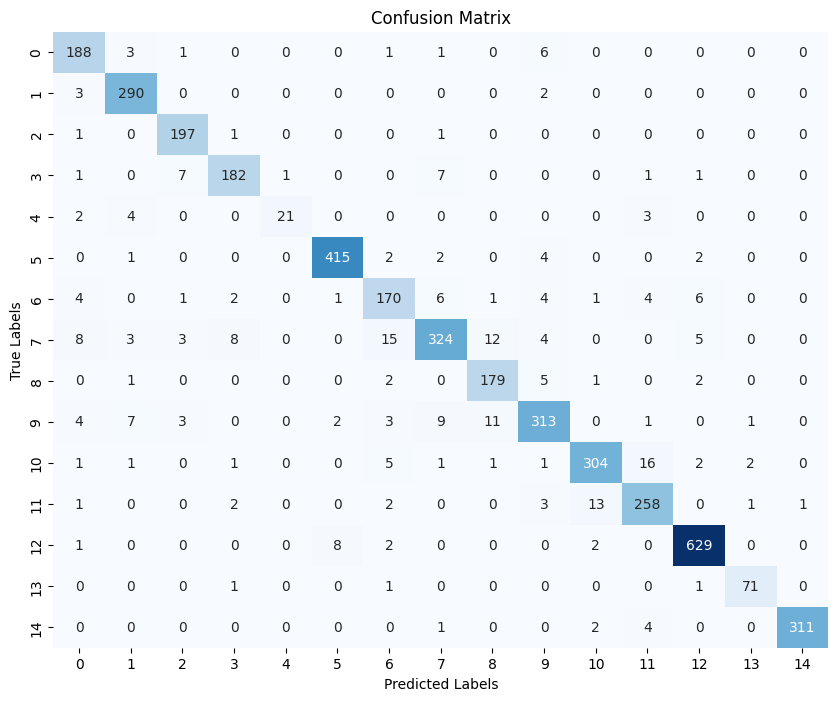

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define a function to preprocess an image
def preprocess_image(image_path):
    img = Image.open(image_path)
    size = (64, 64)
    img = img.resize(size, PIL.Image.LANCZOS)  # Use LANCZOS resampling
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Define the path to your test folder
test_folder_path = '/kaggle/input/plant-village-dataset/PlantVillageDataset/train_val_test/test'

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Loop through each image in the test folder
for folder in os.listdir(test_folder_path):
    if os.path.isdir(os.path.join(test_folder_path, folder)):
        for image_file in os.listdir(os.path.join(test_folder_path, folder)):
            if image_file.endswith('.JPG') or image_file.endswith('.jpg'):
                image_path = os.path.join(test_folder_path, folder, image_file)
                
                # Preprocess the image
                preprocessed_image = preprocess_image(image_path)
                
                # Make predictions using the trained model
                prediction = best_model.predict(preprocessed_image)
                predicted_class = np.argmax(prediction)
                
                # Map the predicted class to its corresponding label
                predicted_label = img_info.loc[img_info['labels_integer'] == predicted_class, 'label'].values[0]
                
                # Store the true and predicted labels
                true_labels.append(folder)
                predicted_labels.append(predicted_label)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


1/1 [==============================] - 0s 33ms/step


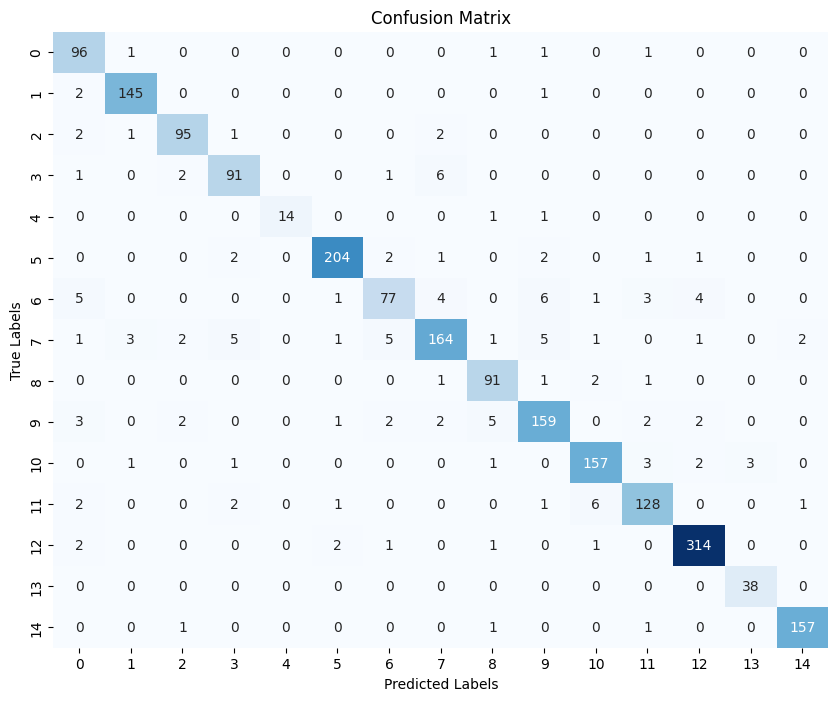

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define a function to preprocess an image
def preprocess_image(image_path):
    img = Image.open(image_path)
    size = (64, 64)
    img = img.resize(size, PIL.Image.LANCZOS)  # Use LANCZOS resampling
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Define the path to your test folder
test_folder_path = '/kaggle/input/plant-village-dataset/PlantVillageDataset/train_val_test/val'

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Loop through each image in the test folder
for folder in os.listdir(test_folder_path):
    if os.path.isdir(os.path.join(test_folder_path, folder)):
        for image_file in os.listdir(os.path.join(test_folder_path, folder)):
            if image_file.endswith('.JPG') or image_file.endswith('.jpg'):
                image_path = os.path.join(test_folder_path, folder, image_file)
                
                # Preprocess the image
                preprocessed_image = preprocess_image(image_path)
                
                # Make predictions using the trained model
                prediction = best_model.predict(preprocessed_image)
                predicted_class = np.argmax(prediction)
                
                # Map the predicted class to its corresponding label
                predicted_label = img_info.loc[img_info['labels_integer'] == predicted_class, 'label'].values[0]
                
                # Store the true and predicted labels
                true_labels.append(folder)
                predicted_labels.append(predicted_label)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
